# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [6]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict



In [11]:
import nltk
nlp = spacy.load('en_core_web_sm')
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\oliwa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


True

In [7]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [12]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [13]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [14]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

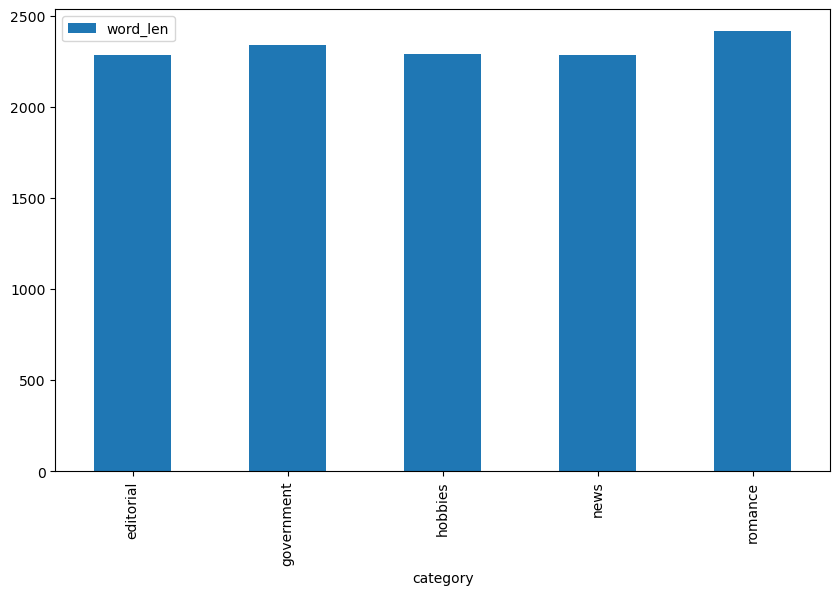

In [15]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [16]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\oliwa\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [17]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both have vectorized representations of the text from the brown corpus, the diifference is that count_text_vectors just shows how much each time a word shows up in the corpus, where as the tfidf_text_vectors contains an importance score , which is how important that word is in the corpus. More frequent words are calculated as being less important

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [20]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [21]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


In [46]:
all_categories = ['editorial','government','news','romance','hobbies'] 

for category in all_categories:

    #grab just the text from this category
    subset = df[df['category'] == category]
    texts = subset['text'].tolist()

    vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
    matrix = vectorizer.fit_transform(texts)


    sums = matrix.sum(axis=0).A1
    features = vectorizer.get_feature_names_out()
    top_n = min(5, len(features))
    top_idx = sums.argsort()[::-1][:top_n]

    print(f"\nCategory: {category}")
    for i in top_idx:
        print(f"  {features[i]}: {sums[i]:.2f}")


Category: editorial
  mr: 2.43
  west: 1.47
  editor: 1.45
  city: 1.44
  east: 1.42

Category: government
  state: 2.73
  development: 1.69
  mr: 1.56
  service: 1.42
  tax: 1.42

Category: news
  mrs: 3.56
  mr: 2.66
  state: 2.08
  000: 1.92
  city: 1.48

Category: romance
  long: 1.74
  mother: 1.60
  room: 1.55
  mrs: 1.44
  young: 1.41

Category: hobbies
  water: 1.49
  inch: 1.40
  design: 1.27
  house: 1.27
  feed: 1.17


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The topics align generally well to the original categories. The best matches were government and romance where the majority ofthe topics were identified to be the same (and news, but the words there were pretty generic). When It comes to editorial, as a human I can understand that the topics are similar in terms of west, east , city corresponding to kennedy, kruschev and united - but it's interesting that the NMF factorization was able to identify more targetted and specific words. 

The main difference appeared to be that instead of identifying hobbies as the fifth category the NMF factorization idenfiied sports (game,league,baseball,ball,team) 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [34]:
svd_text_model = TruncatedSVD(n_components=5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


For my own reference readability, original brown categories

Category: editorial
  mr: 2.43
  west: 1.47
  editor: 1.45
  city: 1.44
  east: 1.42

Category: government
  state: 2.73
  development: 1.69
  mr: 1.56
  service: 1.42
  tax: 1.42

Category: news
  mrs: 3.56
  mr: 2.66
  state: 2.08
  000: 1.92
  city: 1.48

Category: romance
  long: 1.74
  mother: 1.60
  room: 1.55
  mrs: 1.44
  young: 1.41

Category: hobbies
  water: 1.49
  inch: 1.40
  design: 1.27
  house: 1.27
  feed: 1.17

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: Some of the five topc LSA model topics are very similar to the Brown categoires, while others are completely. The editorial and news categories matches very closely (better than NMF) , however topic 0 seems to just be a jumble of very common words, and there's now TWO separate sports categories, both of which didn't exist in the original categories

Q: What is your interpretation of the display topics output? 

A: There appears to be some less obvious patterns which it's picking up on which are difficult to interpret. For example previously I said that topic 4 & 5 appeared to be btoh sports based, but perhaps there's something else going on which separates them ( a scandal with an athlete, talk about local sports vs national etc) 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [44]:
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_



In [30]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA model appears to have done a good job reducing dimmensionality, the top words from each topic appear to be distinct and representative of their respective topics.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Overall it seems like the hobby, government and editorial topics are nearly the same. Topic 04 , may represent the same category as romance. The main difference is in topic 03 which seems more advertisement or business based.


In [32]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [33]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: 

The principal component plot shows how well separated (or not) topics are. Here topics 5,1 and 3 are well separated and very different, even in the lower dimmensional space where as there is a large amount of overlap of topics 2 and 4. The size of the circle corresponds to how much of the total corpus each topic takes up.

The Saliency plot shows which words were most useful in separating topics (more salient at the top). As well as the overall frequency of those words in the corpus. Two interesting conclusions that I'm able to draw from the saliency plot which I wouldn't be able to otherwise:

#1 If I had to guess based on the saliency plot , topic 2 is more national government related topics, where as topic 4 is more LOCAL government related topics.

#2 Such a common word like "said" doesn't seem like it would be useful in separating topics, however loooking at it in the broader context it's obvious that more romance/novel type writing would contain much more dialogue than the news, hence why "said" is so salient.
